# StarCraft - Heart of the Swarm dataset

In [1]:
%matplotlib inline

In [2]:
import choix
import collections
import json
import matplotlib.pyplot as plt
import numpy as np

from math import log
from kseval.models import iterate_dataset
from kseval.models.starcraft import IntransitiveModel, ConstantModel
from kseval.utils import data_path

DATASET = "kdd-starcraft-hots.txt"

In [3]:
counter = collections.Counter()
data = list()
for obs in iterate_dataset(DATASET):
    counter[obs["winner"]] += 1
    counter[obs["loser"]] += 1
    data.append((obs["winner"], obs["loser"]))

In [4]:
n_games = len(data)
n_players = len(counter)

print("number of observations: {:,}".format(n_games))
print("number of players:      {:,}".format(n_players))

number of observations: 28,582
number of players:      2,287


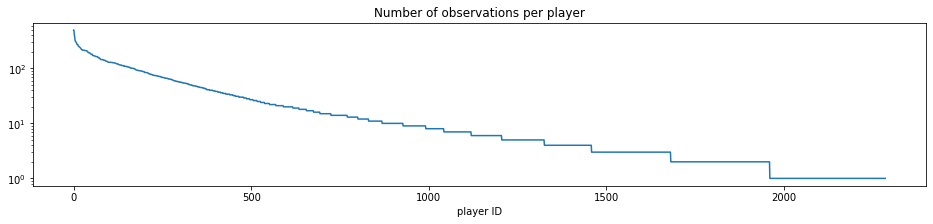

In [5]:
fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.semilogy(sorted(counter.values(), reverse=True))
ax.set_title("Number of observations per player")
ax.set_xlabel("player ID");

In [6]:
i1 = int(n_games * 0.5)
i2 = int(n_games * 0.7)

print("training cutoff: {}".format(i1))
print("test cutoff:     {}".format(i2))

train = data[:i1]
valid = data[i1:i2]
test = data[i2:]

training cutoff: 14291
test cutoff:     20007


## Predictive performance

Compare the performance of several models:

- Bradley–Terry
- Naive
- Blade-Chest
- KickScore Constant
- KickScore Intransitive

In [7]:
loglike = dict()

Bradley-Terry baseline

In [8]:
for alpha in np.logspace(-2, 0, num=10):
    params = choix.opt_pairwise(n_players, train, alpha=alpha)
    ll = 0
    for x in valid:
        pw, _ = choix.probabilities(x, params)
        ll += log(pw)
    print("alpha = {:.5f}, ll = {:.3f}".format(alpha, ll / len(valid)))

alpha = 0.01000, ll = -0.590
alpha = 0.01668, ll = -0.581
alpha = 0.02783, ll = -0.573
alpha = 0.04642, ll = -0.568
alpha = 0.07743, ll = -0.564
alpha = 0.12915, ll = -0.563
alpha = 0.21544, ll = -0.565
alpha = 0.35938, ll = -0.570
alpha = 0.59948, ll = -0.578
alpha = 1.00000, ll = -0.589


In [9]:
params = choix.opt_pairwise(n_players, train, alpha=0.12915)
ll = 0
for x in test:
    pw, _ = choix.probabilities(x, params)
    ll += log(pw)

loglike["bt"] = ll / len(test)

Naive baseline

In [10]:
counts = collections.defaultdict(lambda: 1)
for w, l in train:
    counts[(w, l)] += 1

In [11]:
ll = 0
for w, l in test:
    pw = counts[(w, l)] / (counts[(w, l)]  + counts[(l, w)] )
    ll += log(pw)
    
loglike["naive"] = ll / len(test)

IntransitiveModel

In [12]:
%%time
model = IntransitiveModel(dataset="hots", cvar=4.996, xvar=4.342)
model.fit()

CPU times: user 1min 29s, sys: 223 ms, total: 1min 29s
Wall time: 1min 29s


False

In [13]:
n_obs, log_loss, acc = model.evaluate()
loglike["intransitive"] = -log_loss / n_obs

ConstantModel

In [14]:
%%time
model = ConstantModel(dataset="hots", cvar=2.124)
model.fit()

CPU times: user 54.2 s, sys: 60 ms, total: 54.3 s
Wall time: 54.3 s


True

In [15]:
n_obs, log_loss, acc = model.evaluate()
loglike["constant"] = -log_loss / n_obs

Blade-Chest model

In [16]:
loglike["bc"] = -0.505

### Results

In [17]:
print("model         neg. log-like")
print("---------------------------")
fmt = "{: <12}         {:.3f}"

for model in ("naive", "bt", "constant", "bc", "intransitive"):
    ll = loglike[model]
    print(fmt.format(model, ll))

model         neg. log-like
---------------------------
naive                -0.579
bt                   -0.566
constant             -0.565
bc                   -0.505
intransitive         -0.478


In [18]:
with open(data_path("fig/starcraft-hots.json"), "w") as f:
    json.dump(loglike, f)